In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.gridspec import GridSpec
import seaborn as sns
import plotly.express as px
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn import preprocessing
from sklearn import utils
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
import plotly.express as px
from plotly.subplots import make_subplots
%matplotlib inline
import plotly.graph_objs as go



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#reading data from csv files

train_df = pd.read_csv(' train.csv')
store_df = pd.read_csv('stores.csv')
feature_df = pd.read_csv('features.csv')

FileNotFoundError: [Errno 2] No such file or directory: ' train.csv'

In [4]:
#merging data and filling null values
feature_store = feature_df.merge(store_df, how='inner', on = "Store").reset_index(drop=True)
feature_store.head()
train = train_df.merge(feature_store, how='inner', on = ['Store','Date','IsHoliday']).sort_values(by=['Store','Dept','Date']).reset_index(drop=True)
train.head()

train.fillna(0,inplace=True)
li = [x for x in train.columns if 'MarkDown' in x ]
print(li)
train['isMarkdown'] = train[li].sum(axis=1).astype('bool')
train.head()


['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,isMarkdown
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,False
1,1,1,2010-02-12,46039.49,True,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,A,151315,False
2,1,1,2010-02-19,41595.55,False,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,A,151315,False
3,1,1,2010-02-26,19403.54,False,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,A,151315,False
4,1,1,2010-03-05,21827.90,False,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,A,151315,False


In [5]:
#adding datetime columns
train['Date']  = pd.to_datetime(train['Date'])
train['Day']   = train['Date'].dt.day
train['Week']  = train['Date'].dt.isocalendar().week
train['Month'] = train['Date'].dt.month
train['Year']  = train['Date'].dt.year
train.head(1000)
#converting datatypes types to category
train['Year']=train['Year'].astype('category')
train['Week']=train['Week'].astype('category')

train.info()

train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 21 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   MarkDown1     421570 non-null  float64       
 8   MarkDown2     421570 non-null  float64       
 9   MarkDown3     421570 non-null  float64       
 10  MarkDown4     421570 non-null  float64       
 11  MarkDown5     421570 non-null  float64       
 12  CPI           421570 non-null  float64       
 13  Unemployment  421570 non-null  float64       
 14  Type          421570 non-null  object        
 15  Size          421

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,MarkDown5,CPI,Unemployment,Type,Size,isMarkdown,Day,Week,Month,Year
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,...,0.0,211.096358,8.106,A,151315,False,5,5,2,2010
1,1,1,2010-02-12,46039.49,True,38.51,2.548,0.0,0.0,0.0,...,0.0,211.242170,8.106,A,151315,False,12,6,2,2010
2,1,1,2010-02-19,41595.55,False,39.93,2.514,0.0,0.0,0.0,...,0.0,211.289143,8.106,A,151315,False,19,7,2,2010
3,1,1,2010-02-26,19403.54,False,46.63,2.561,0.0,0.0,0.0,...,0.0,211.319643,8.106,A,151315,False,26,8,2,2010
4,1,1,2010-03-05,21827.90,False,46.50,2.625,0.0,0.0,0.0,...,0.0,211.350143,8.106,A,151315,False,5,9,3,2010


In [6]:
#storetype piechart
typecounts = train.Type.value_counts().to_dict()
df = pd.DataFrame(list(typecounts.items()), columns=['Store_Type', 'Counts'])

fig = px.pie(df, values='Counts', names='Store_Type',
             title='Popularity of Store Types',labels='Store_Type',color_discrete_sequence=px.colors.qualitative.T10)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [7]:
#average sales/storetype barplot
avgweeklysales = train.groupby('Type')['Weekly_Sales'].mean().to_dict()
df = pd.DataFrame(list(avgweeklysales.items()), columns=['Store_Type', 'AvgSales'])

fig = px.bar(df, 
             x="Store_Type", 
             y="AvgSales",  
             title="Avergae Sales - Per Store",
             color_discrete_sequence=px.colors.qualitative.T10)
fig.show()

In [ ]:
#averagee department sales barblot
dept_sales = train.groupby('Dept')['Weekly_Sales'].mean().sort_values(ascending=False)


fig = px.bar(dept_sales, 
             x=dept_sales.index, 
             y=dept_sales.values,  
             title="Average Sales for all stores Per Department",
             labels={'x':'Dept', 'y':'Sales'},
             color_discrete_sequence=["#DC143C"])

fig.update_xaxes(tick0=1, dtick=1)

fig.show()

In [ ]:
train.groupby('isMarkdown').count()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Day,Week,Month,Year
isMarkdown,,,,,,,,,,,,,,,,,,,,
False,270138,270138,270138,270138,270138,270138,270138,270138,270138,270138,270138,270138,270138,270138,270138,270138,270138,270138,270138,270138
True,151432,151432,151432,151432,151432,151432,151432,151432,151432,151432,151432,151432,151432,151432,151432,151432,151432,151432,151432,151432


<AxesSubplot: xlabel='Week', ylabel='Weekly_Sales'>

<Figure size 1500x500 with 0 Axes>

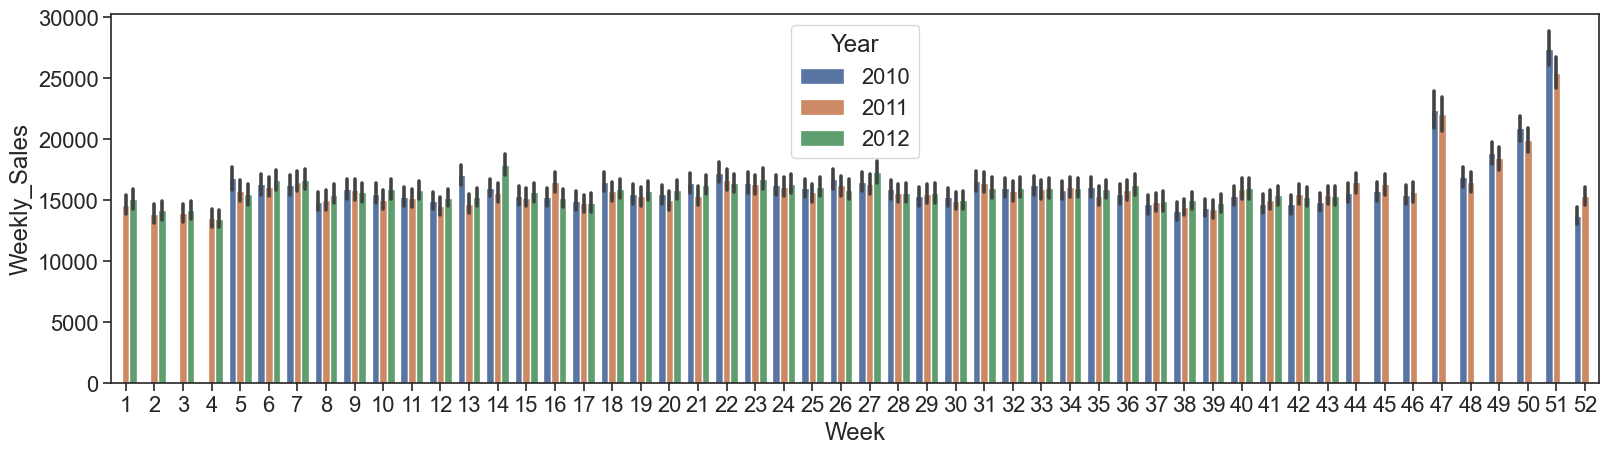

In [ ]:
#Weekly sales barplot
#train__df=train.groupby(["Week"])["Weekly_Sales"].mean()
#train__df.sort_values(by='Weekly_Sales').plot()
#sns.lineplot(x='Week', y='Weekly_Sales', data=train, hue='Year', markers=None)

plt.figure(figsize=(15,5))

sns.set(style='ticks',context='notebook',font_scale=1.5)  
fig, ax = plt.subplots(figsize=(20, 5),dpi=96)
sns.barplot(x='Week', y='Weekly_Sales',data=train, hue=train['Year'])


<AxesSubplot: xlabel='Week', ylabel='Weekly_Sales'>

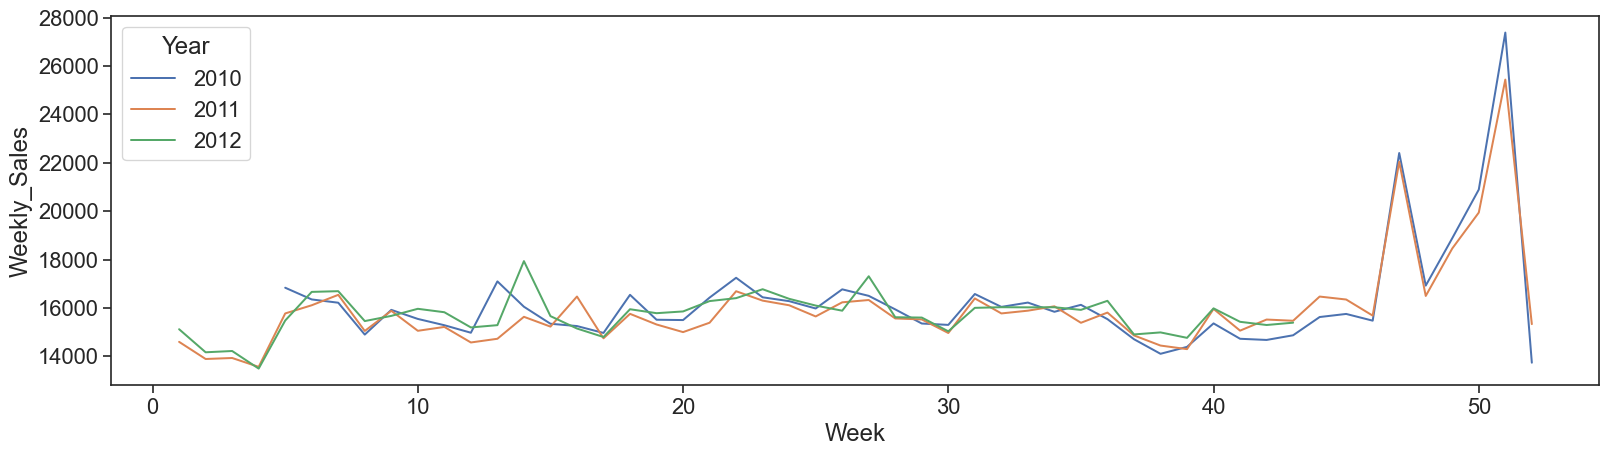

In [ ]:
#average weekly sales per year lineplot
fig, ax = plt.subplots(figsize=(20, 5), dpi=96)


sns.lineplot(x='Week', y='Weekly_Sales', data=train, hue='Year', errorbar=None,)


<AxesSubplot: xlabel='Week', ylabel='Weekly_Sales'>

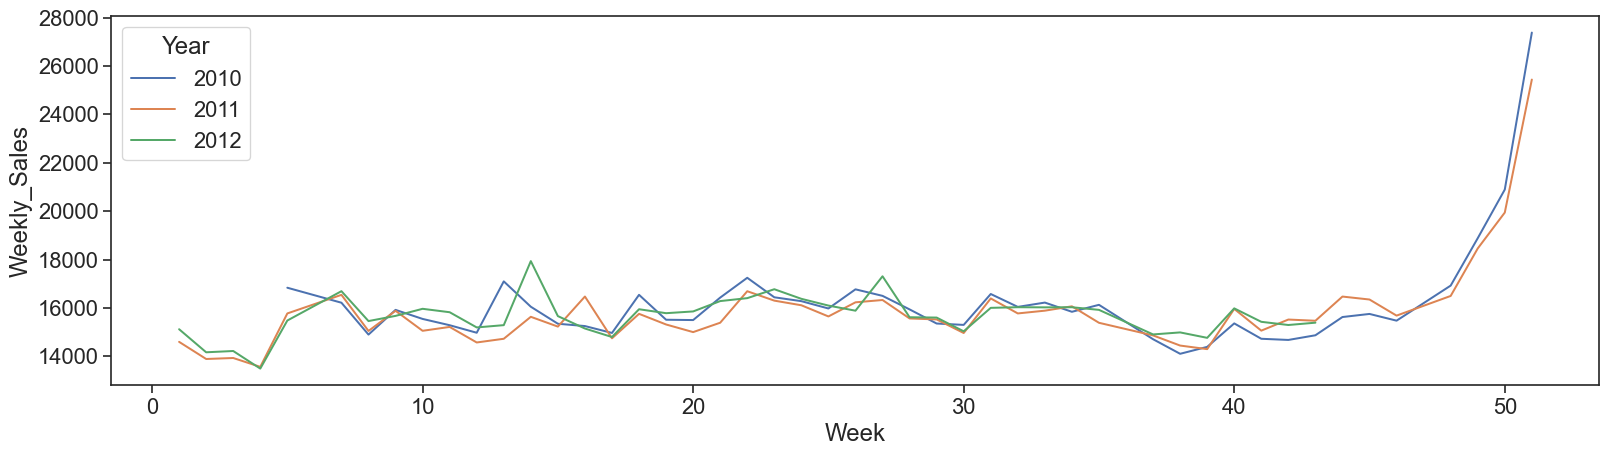

In [ ]:
#average weekly sales per year without Holidays lineplot
#sns.set(style='ticks', context='notebook', font_scale=1.5)
fig, ax = plt.subplots(figsize=(20, 5), dpi=96)
dummy1 = train[train['IsHoliday']==False]
dummy1['Week'].astype('category')
sns.lineplot(x='Week', y='Weekly_Sales', data=dummy1, hue='Year', errorbar=None)


In [ ]:
#isholiday sales and counts
holiday_sales = train.groupby('IsHoliday')['Weekly_Sales'].mean()
holiday_counts = train.IsHoliday.value_counts()

fig = make_subplots(rows=1, cols=2, subplot_titles=("Holidays/Nonholidays Sales", "Holidays/Nonholidays Counts"))

fig.add_trace(go.Bar(x=holiday_sales.index, y=holiday_sales.values, marker=dict(color=[4, 6, 7], coloraxis="coloraxis1")),1, 1)

fig.add_trace(go.Bar(x=holiday_counts.index, y=holiday_counts.values,marker=dict(color=[4, 6, 7], coloraxis="coloraxis2")),1, 2)

fig.update_layout(coloraxis=dict(colorscale='rdbu'), showlegend=False)
fig.show()


Text(0, 0.5, 'Sales')

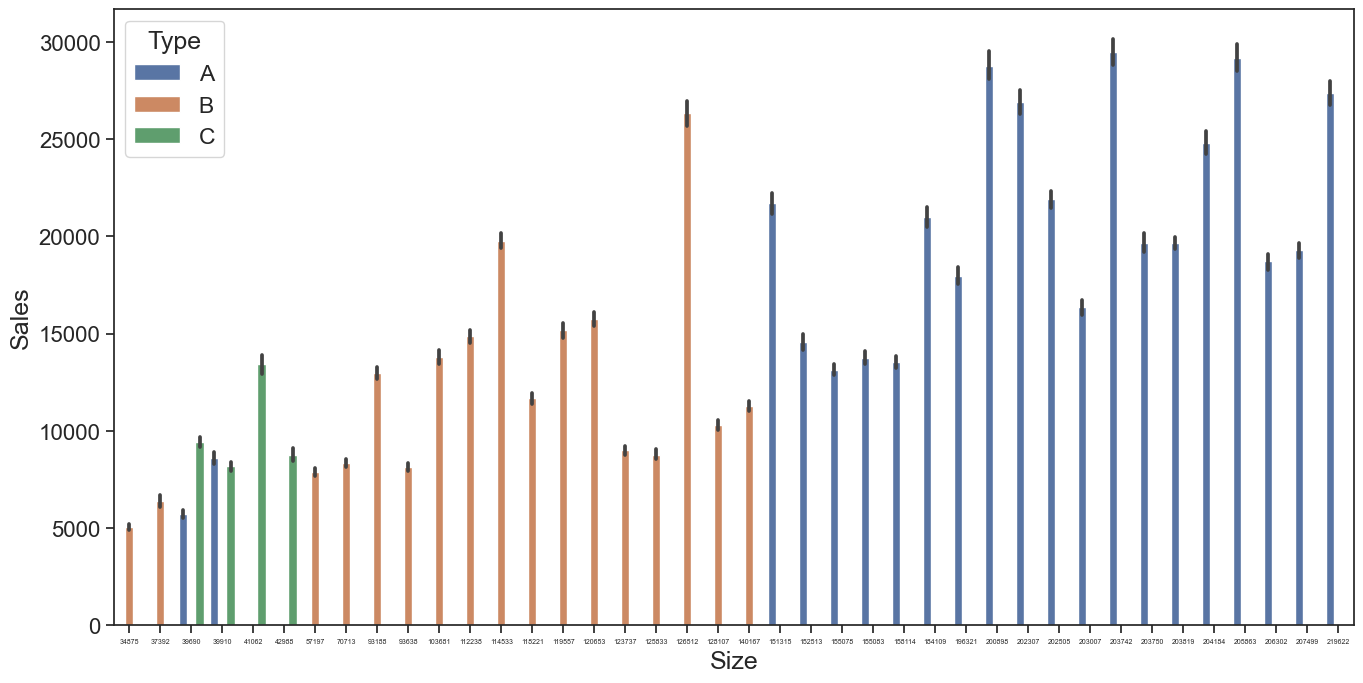

In [ ]:
#size of the store vs sales
plt.figure(figsize=(16,8))
sns.barplot(x=train.Size, y=train.Weekly_Sales, hue=train.Type)

plt.xticks( fontsize=5)
plt.yticks( fontsize=16)
plt.xlabel('Size', fontsize=18)
plt.ylabel('Sales', fontsize=18)

<AxesSubplot: xlabel='Store', ylabel='Weekly_Sales'>

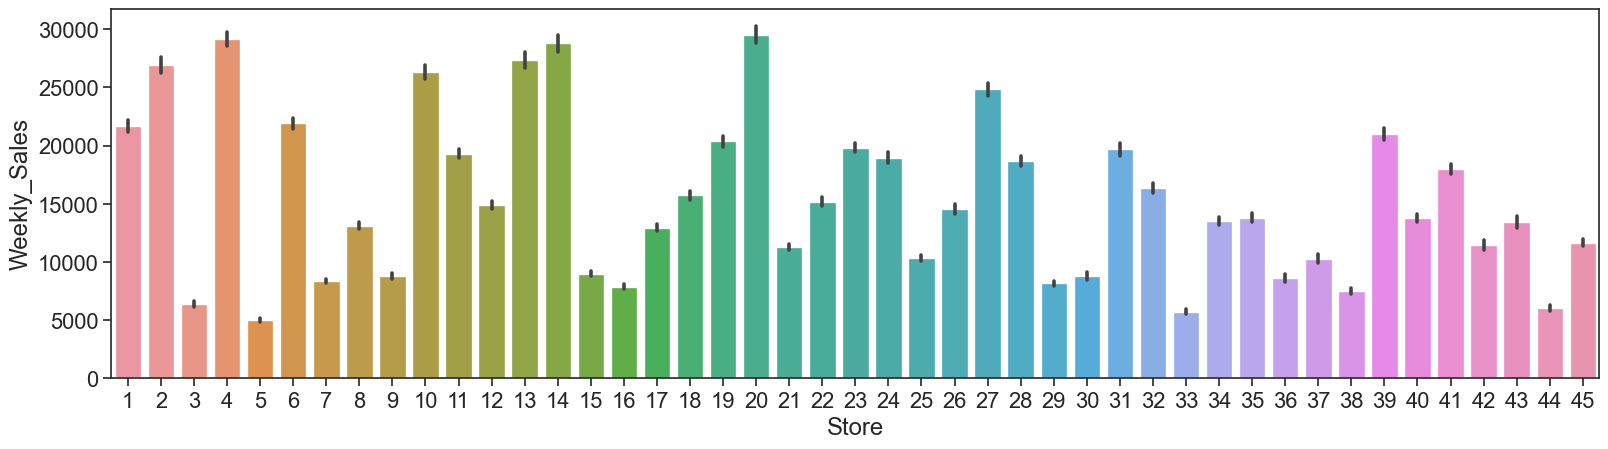

In [ ]:
#average sales per store

fig, ax = plt.subplots(figsize=(20, 5), dpi=96)
sns.barplot(data=train,x = 'Store', y='Weekly_Sales')

,Weekly_Sales
Store,
5,5053.415813
33,5728.414053
44,6038.929814
3,6373.033983
38,7492.478460
16,7863.224124
29,8158.810609


,Weekly_Sales
Store,
27,24826.984536
10,26332.303819
2,26898.070031
13,27355.136891
14,28784.851727
4,29161.210415
20,29508.301592


,Weekly_Sales
Store,
5,5053.415813
33,5728.414053
44,6038.929814
3,6373.033983
38,7492.478460
16,7863.224124
29,8158.810609
27,24826.984536
10,26332.303819


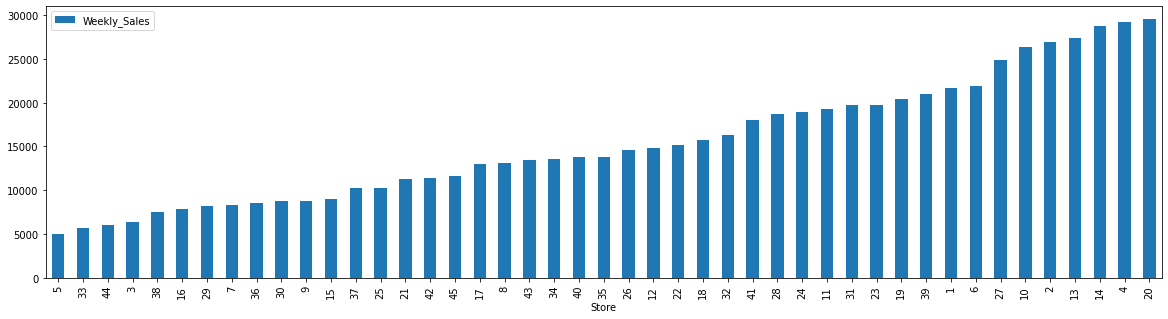

In [8]:
#splitting top/bot 
avg_store_sales = train.groupby('Store')['Weekly_Sales'].mean().to_frame().sort_values(by='Weekly_Sales')
avg_store_sales.head(100)
avg_store_sales.plot(kind='bar',figsize=(20, 5))

top5 = avg_store_sales.head(7)
bot5 = avg_store_sales.tail(7)
display(top5,bot5)

top_bot = pd.concat([top5, bot5], ignore_index=False, sort=False)
top_bot.head(100)



In [10]:
top_bot=top_bot.reset_index()
x=list(top_bot['Store'])
x


[5, 33, 44, 3, 38, 16, 29, 27, 10, 2, 13, 14, 4, 20]

In [11]:
train=train.reset_index()

result = train[train["Store"].isin(x)]
result["Store"].unique()
result=result.groupby('Store').mean().head(100).sort_values('Weekly_Sales')


In [23]:
result

,index,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,isMarkdown,Day,Month
Store,,,,,,,,,,,,,,,,,
5,44289.0,41.285254,5053.415813,0.071119,69.203619,3.220912,1079.143440,300.162839,235.176435,395.045179,915.256248,216.6,6.30,34875.0,0.358151,15.693966,6.446383
33,317291.0,46.674888,5728.414053,0.069832,76.798159,3.589131,120.598730,33.042724,0.482249,1.523433,613.657057,128.7,8.50,39690.0,0.368121,15.659935,6.486203
44,408348.0,46.740271,6038.929814,0.069605,53.901826,3.294224,183.666965,28.634207,5.740923,2.649944,320.745345,128.7,6.71,39910.0,0.365602,15.649742,6.467987
3,24999.5,41.038623,6373.033983,0.070053,71.298627,3.219112,1104.843804,294.276057,288.622421,317.644571,455.513285,219.4,7.18,37392.0,0.359119,15.684484,6.452523
38,357395.5,46.247080,7492.478460,0.069275,70.378164,3.617363,151.676540,51.640020,4.442696,7.133337,578.955853,128.7,13.09,39690.0,0.367291,15.655121,6.451915
16,152742.0,42.655936,7863.224124,0.071270,45.006926,3.248837,1405.274536,261.867284,281.312568,458.882577,1049.573482,193.8,6.47,57197.0,0.368739,15.667690,6.464259
29,281820.0,43.182232,8158.810609,0.070650,54.865961,3.441940,1917.248498,532.621411,366.070905,494.806918,894.233960,135.1,9.81,93638.0,0.356108,15.671391,6.460391
27,261867.0,44.467971,24826.984536,0.070318,57.310636,3.579829,4451.228809,1504.281119,662.474757,2118.176731,2040.160212,139.0,8.00,204184.0,0.357555,15.679609,6.452127
10,92681.0,44.033931,26332.303819,0.070189,72.147831,3.572490,3438.459998,1472.609746,1105.554312,1538.135265,1914.534532,128.7,8.37,126512.0,0.353466,15.675812,6.440620


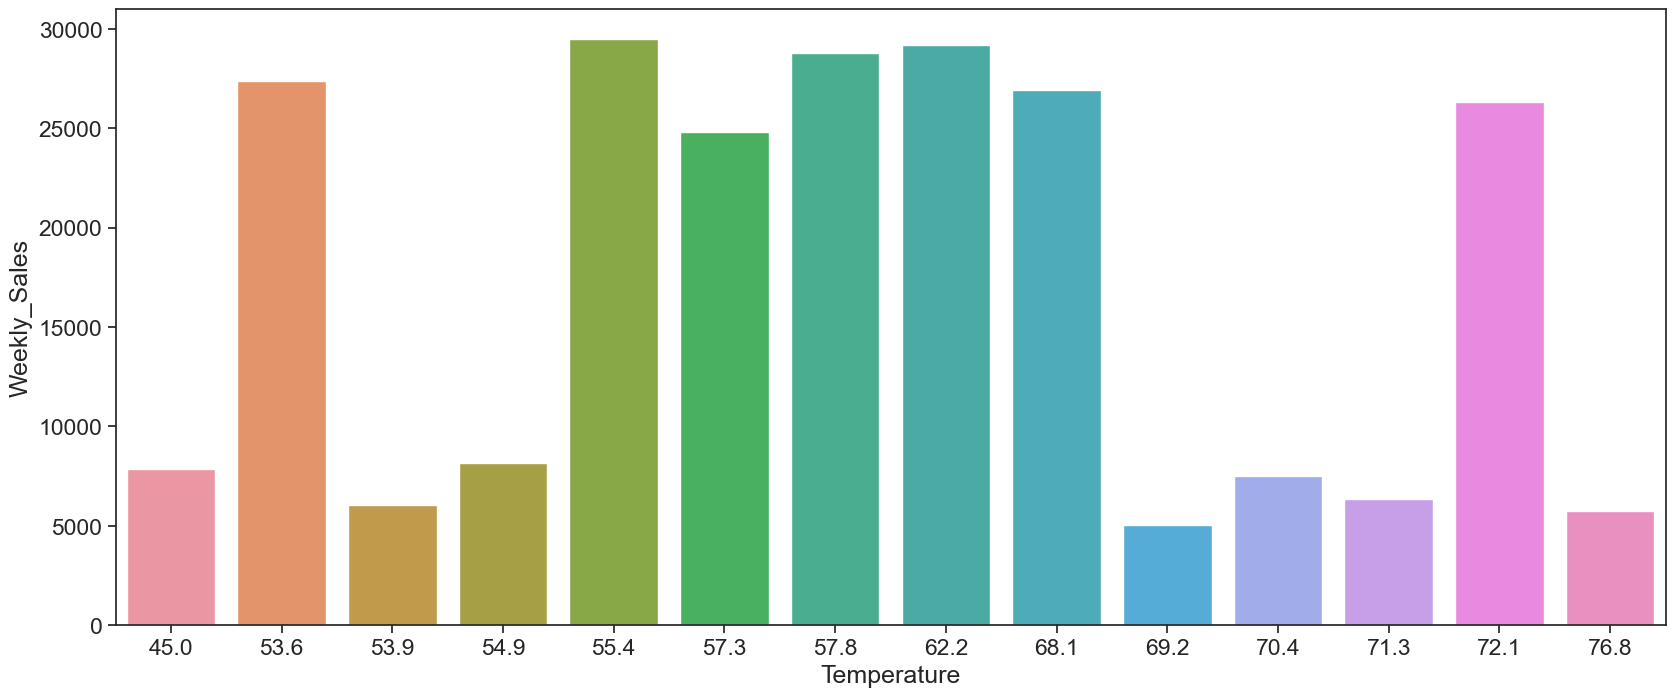

In [ ]:
#templreture vs weekly sales on top/bot features
plt.figure(figsize = (20,8))
result['Temperature']=result['Temperature'].round(decimals = 1)
ax = sns.barplot(x = 'Temperature', y = 'Weekly_Sales' , data = result)

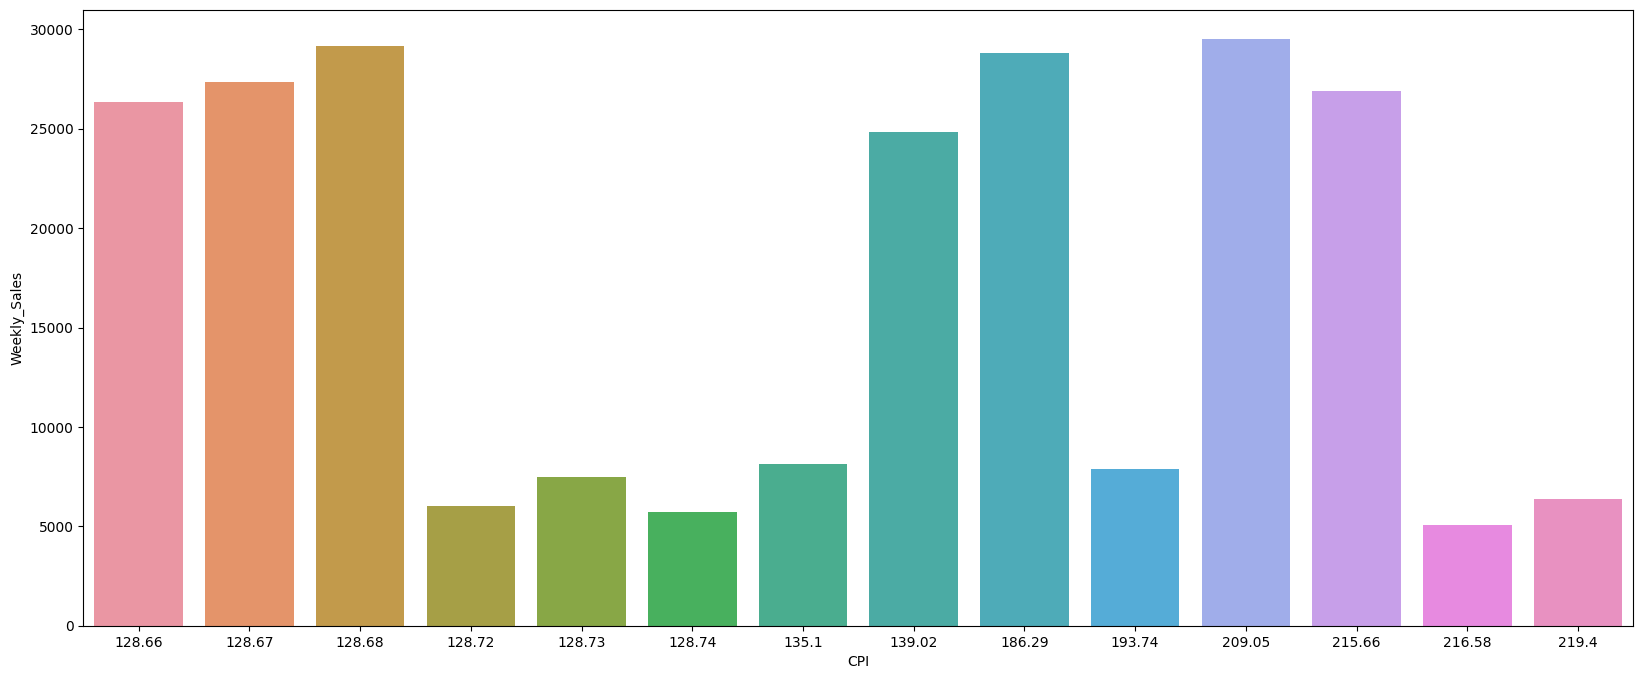

In [ ]:
#CPI vs weekly sales on top/bot features
plt.figure(figsize = (20,8))

result['CPI']=result['CPI'].round(decimals = 2)

ax = sns.barplot(x = 'CPI', y = 'Weekly_Sales' , data = result)

In [26]:
result['CPI']=result['CPI'].round(decimals = 2)
result.groupby('CPI')['Weekly_Sales']


CPI
128.7    102108.473452
135.1      8158.810609
139.0     24826.984536
186.3     28784.851727
193.8      7863.224124
209.0     29508.301592
215.6     26898.070031
216.6      5053.415813
219.4      6373.033983
Name: Weekly_Sales, dtype: float64

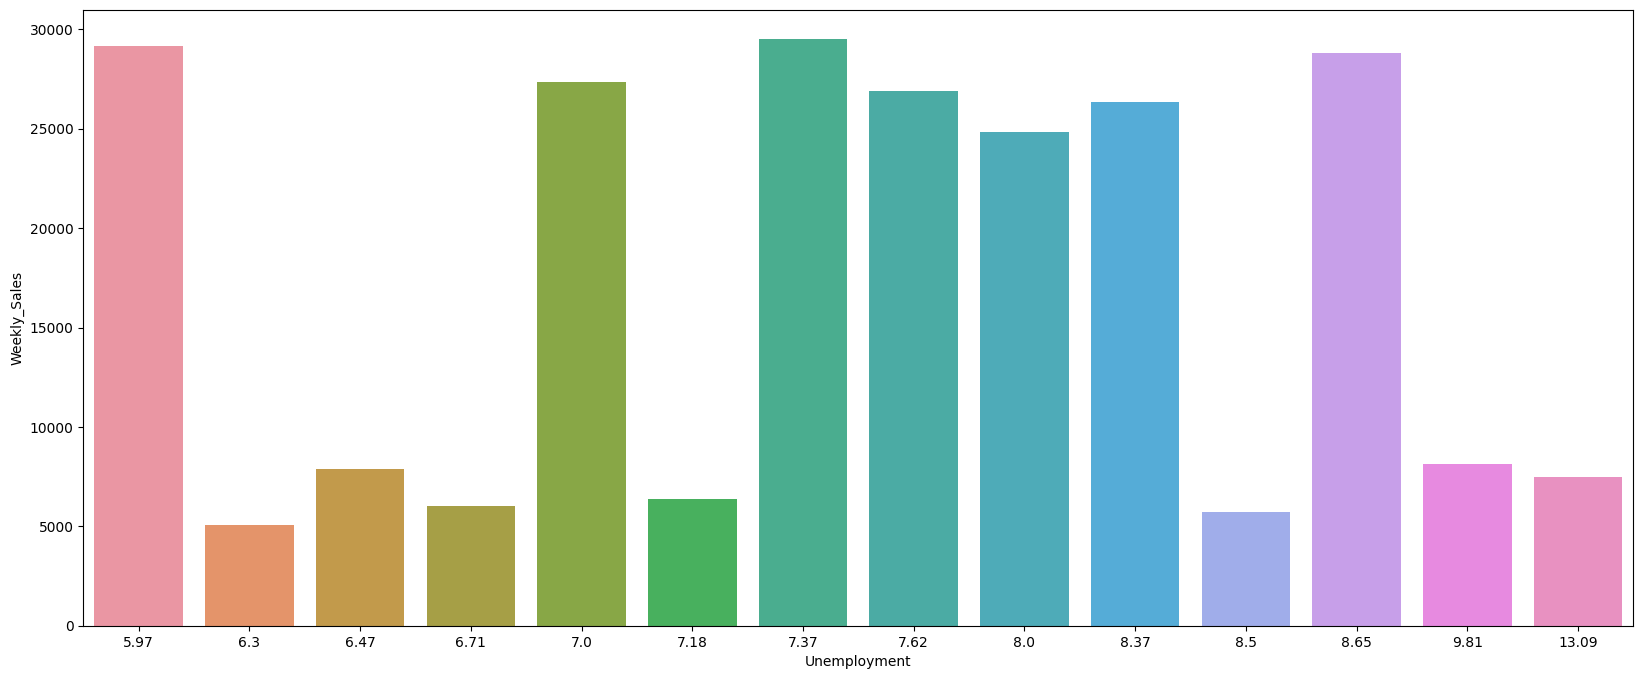

In [ ]:
#unemployment vs weekly sales on top/bot features
plt.figure(figsize = (20,8))

result['Unemployment']=result['Unemployment'].round(decimals = 2)

ax = sns.barplot(x = 'Unemployment', y = 'Weekly_Sales' , data = result)

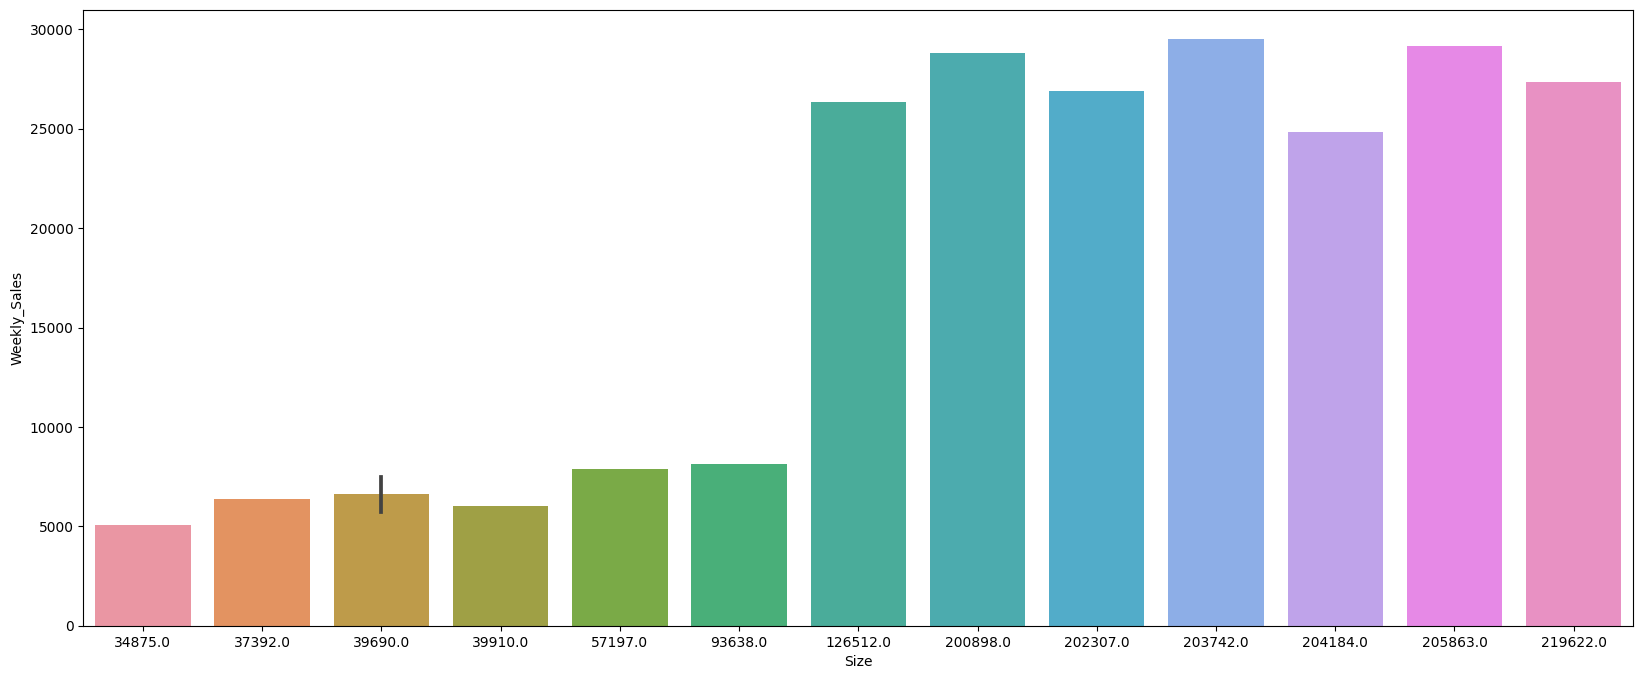

In [ ]:
#size vs weekly sales on top/bot features
plt.figure(figsize = (20,8))


ax = sns.barplot(x = 'Size', y = 'Weekly_Sales' , data = result)

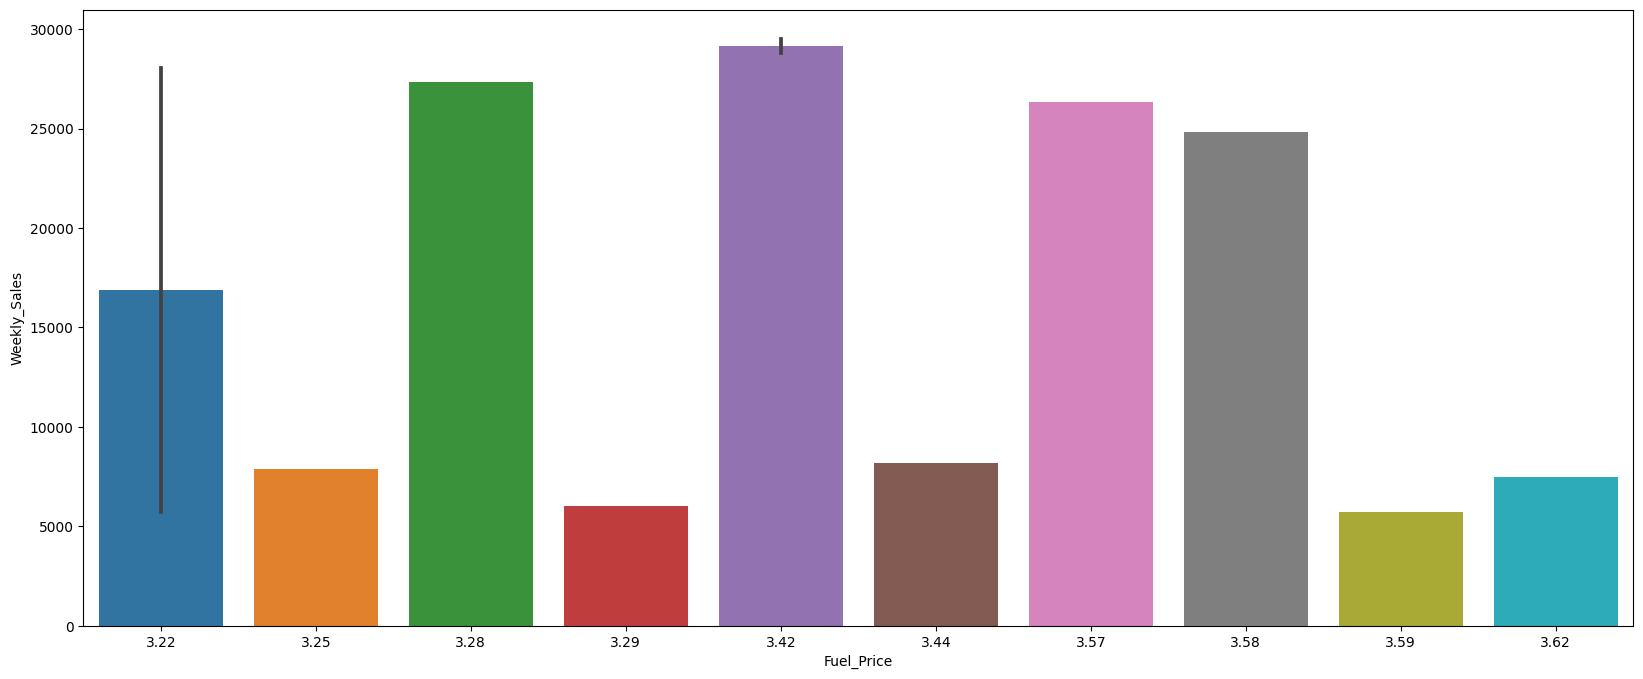

In [ ]:
#Fuel_Price vs weekly sales on top/bot features
plt.figure(figsize = (20,8))
result['Fuel_Price']=result['Fuel_Price'].round(decimals = 2)


ax = sns.barplot(x = 'Fuel_Price', y = 'Weekly_Sales' , data = result)

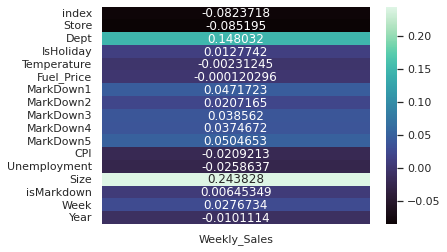

In [60]:
cmap = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)
pltl = sns.heatmap(df[["Weekly_Sales"]].drop('Weekly_Sales'),annot=True,fmt='g'cmap=cmap )


<ipython-input-61-981acfcaee5f>:11: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



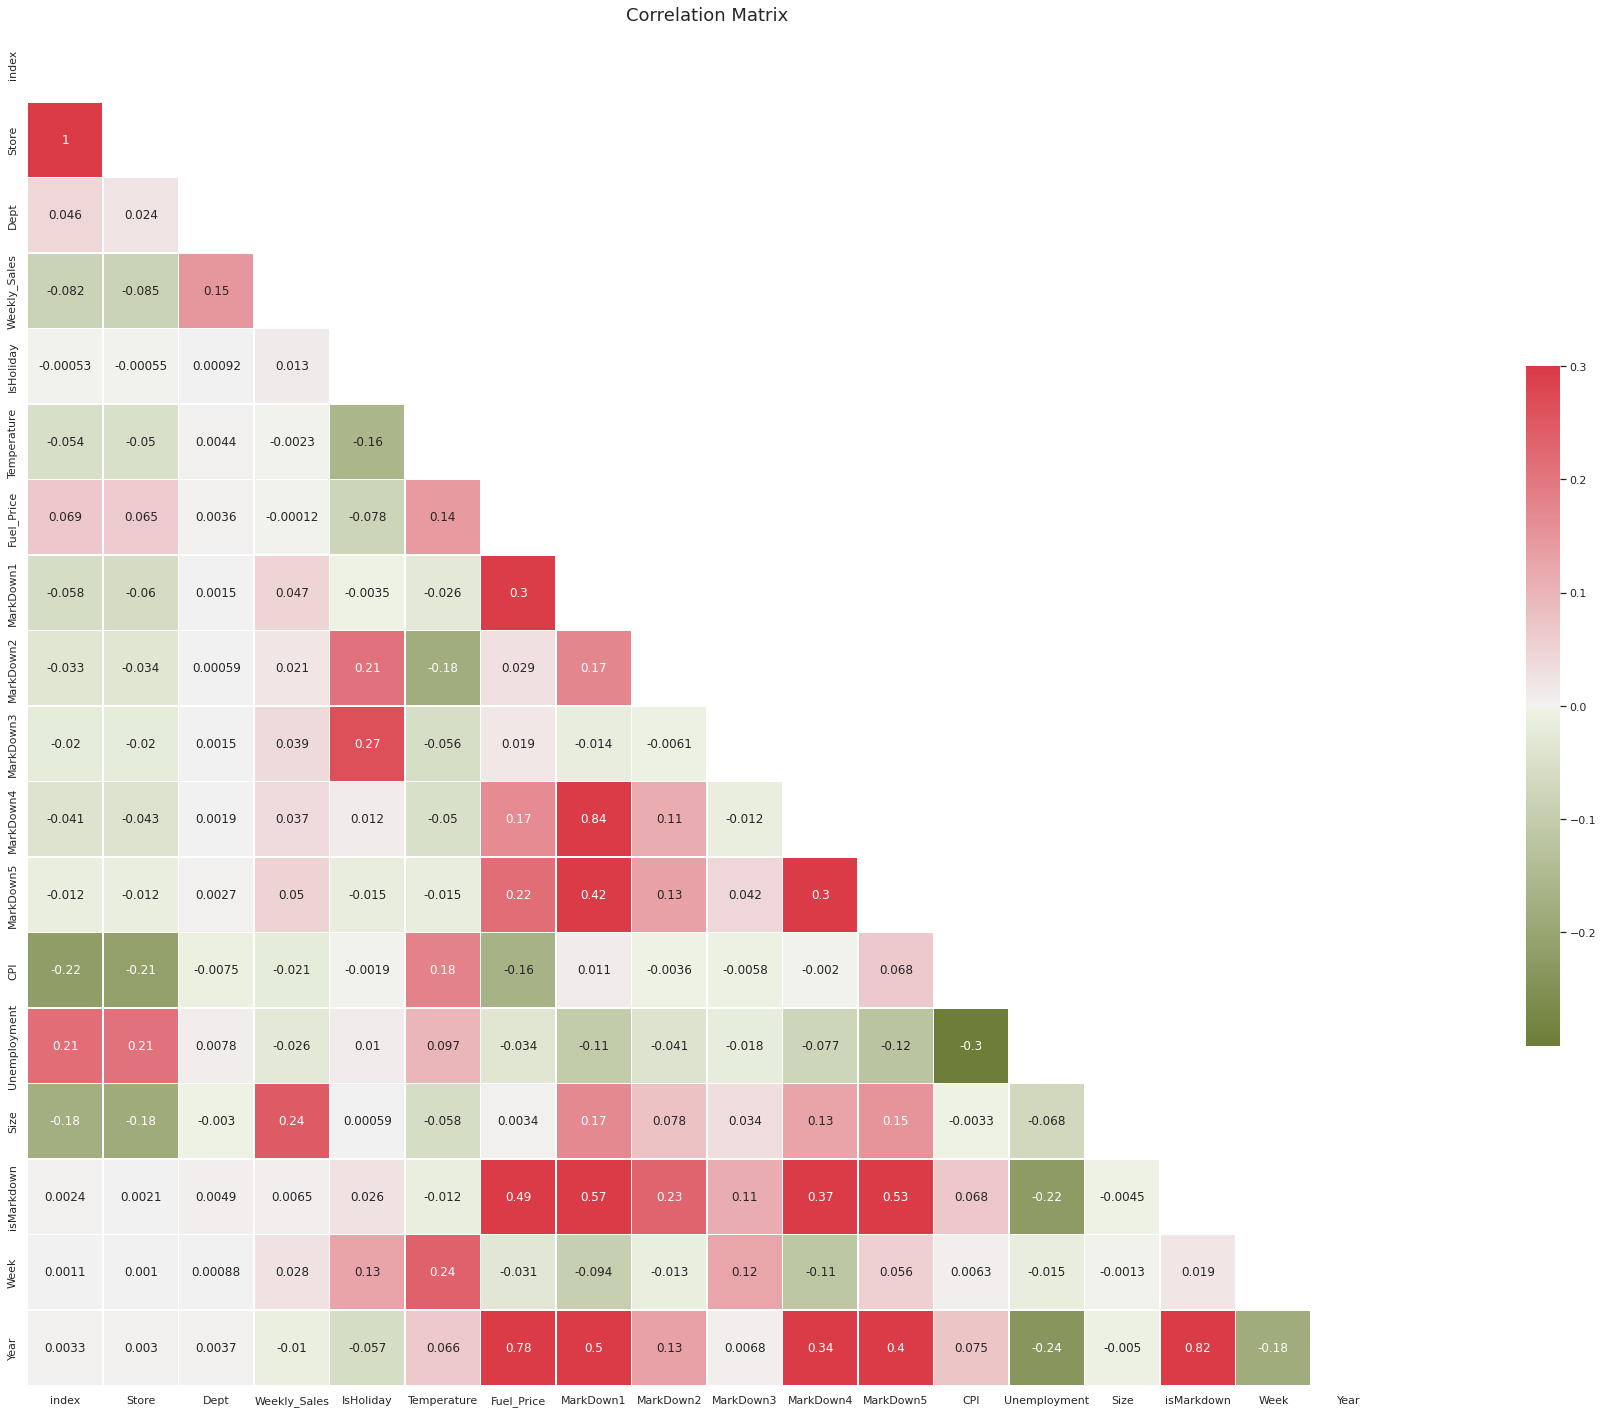

In [61]:
#correlation matrix
train['Year']=train['Year'].astype('int')
train['Week']=train['Week'].astype('int')
train['Day']=train['Day'].astype('category')
train['Month']=train['Month'].astype('category')

sns.set(style="white")

corr = train.corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(50, 25))

cmap = sns.diverging_palette(100, 10, as_cmap=True)

plt.title('Correlation Matrix', fontsize=18)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.3, cbar_kws={"shrink": .5}, annot=True)

plt.show()

In [ ]:
#mapping types 
train['Type']=train['Type'].map({'A':1, 'B':2,'C':3})
print(train['Type'])

0         1
1         1
2         1
3         1
4         1
         ..
421565    2
421566    2
421567    2
421568    2
421569    2
Name: Type, Length: 421570, dtype: int64


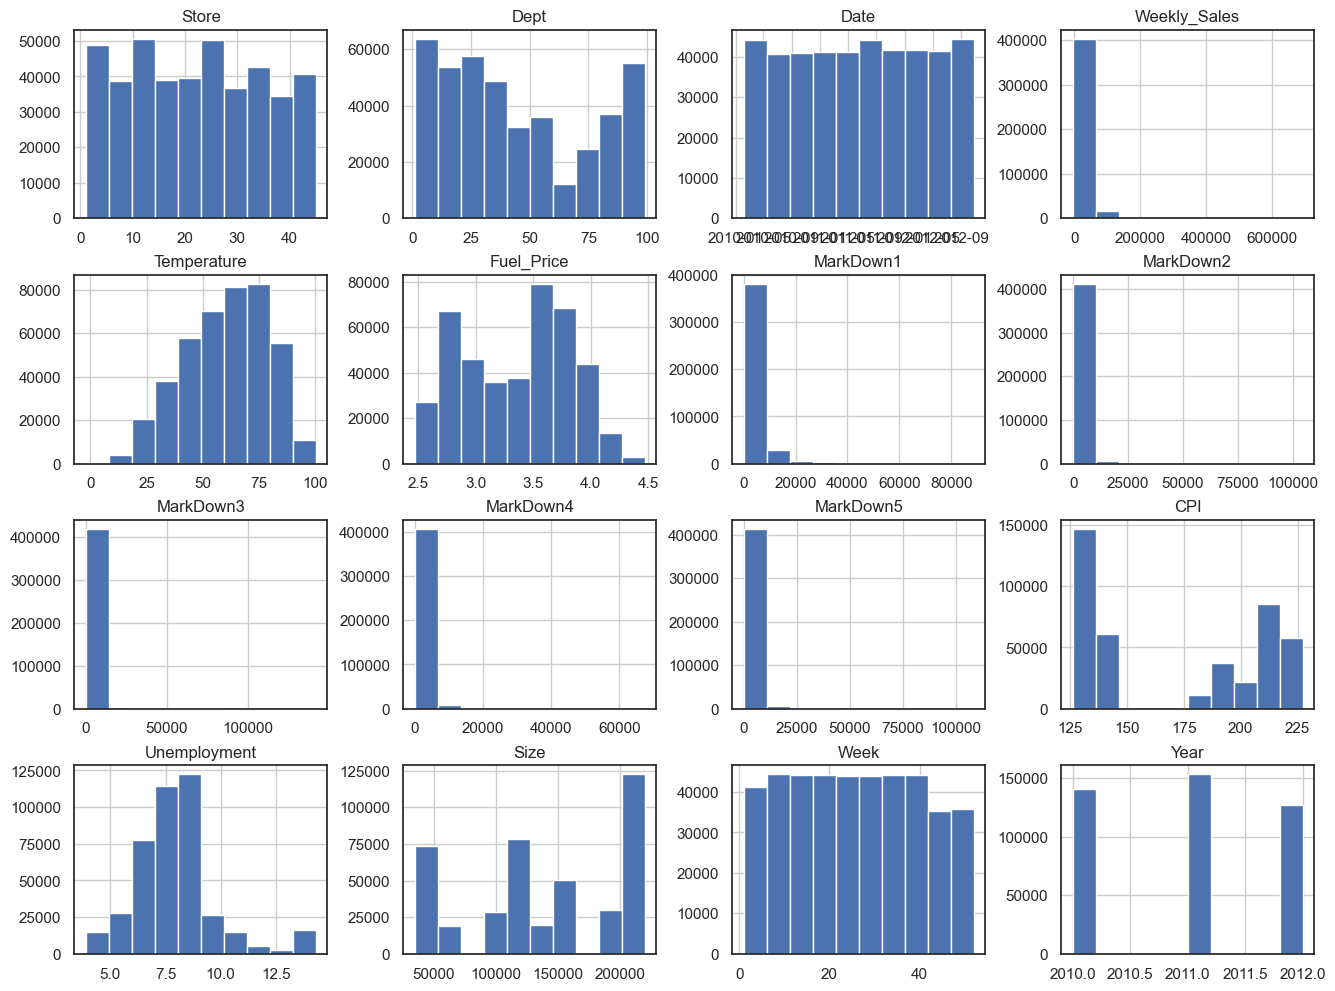

In [ ]:
train.hist(linewidth=1, figsize=(16,12))
plt.show()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_7788\4002267633.py:7: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



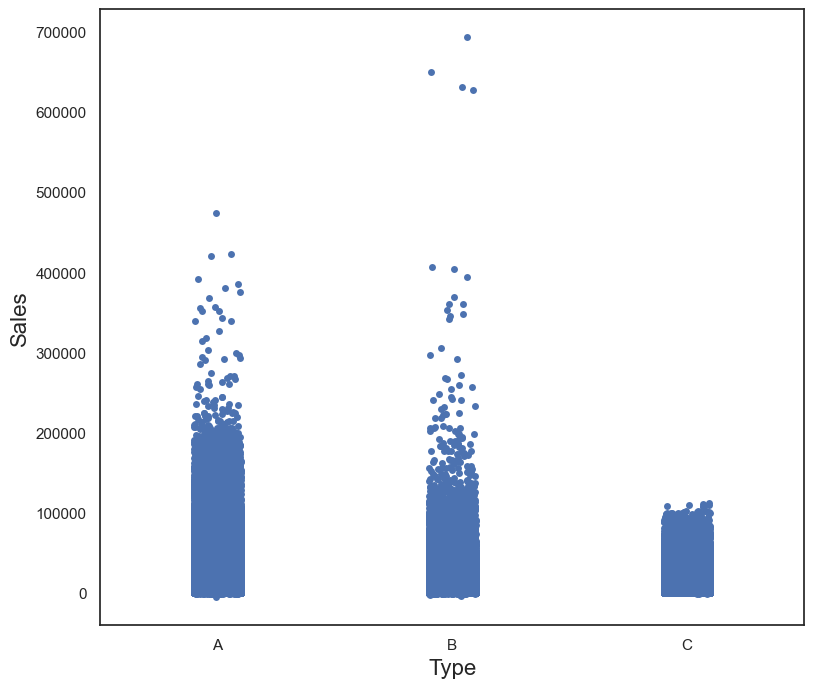

In [ ]:
#storetypes stripplot
fig = plt.figure(figsize=(20,8))
gs = GridSpec(1,2)
sns.stripplot(y=train.Weekly_Sales, x=train['Type'], ax=fig.add_subplot(gs[0,1]))
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Type', fontsize=16)
fig.show()